<a href="https://colab.research.google.com/github/azibit/COMS_559/blob/master/Building_2D_CNN_for_559_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Importing Necessary Libraries**

In [0]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder

import os
import glob
np.random.seed(1111)
import tensorflow as tf

import pandas as pd
from sklearn import preprocessing

**Download Files From AWS**

In [0]:
!wget -c "https://aidris559lab4.s3.amazonaws.com/clean_virus_dataset.zip"

--2020-05-09 15:42:09--  https://aidris559lab4.s3.amazonaws.com/clean_virus_dataset.zip
Resolving aidris559lab4.s3.amazonaws.com (aidris559lab4.s3.amazonaws.com)... 52.216.238.75
Connecting to aidris559lab4.s3.amazonaws.com (aidris559lab4.s3.amazonaws.com)|52.216.238.75|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 22055566 (21M) [application/zip]
Saving to: ‘clean_virus_dataset.zip’

clean_virus_dataset 100%[===================>]  21.03M  8.88MB/s    in 2.4s    

2020-05-09 15:42:13 (8.88 MB/s) - ‘clean_virus_dataset.zip’ saved [22055566/22055566]



In [0]:
!unzip clean_virus_dataset.zip

In [0]:
!mkdir data_store

In [0]:
cd data_store/

/content/data_store


In [0]:
files = glob.glob("../data/*")
print("Total number of files: ", len(files))
print("Showing first 10 files...")
files[:10]

Total number of files:  3576
Showing first 10 files...


['../data/clean_968.csv',
 '../data/clean_1688.csv',
 '../data/virus_1417.csv',
 '../data/clean_1129.csv',
 '../data/virus_1103.csv',
 '../data/clean_574.csv',
 '../data/clean_917.csv',
 '../data/virus_1031.csv',
 '../data/virus_560.csv',
 '../data/virus_1028.csv']

In [0]:
file_headers = ["USER", "PID", "%CPU", "%MEM" , "VSZ" ,  "RSS",  "TTY", "STAT", "START", "TIME", "COMMAND"]
# columns_to_numericalize = ['USER', 'TTY', 'STAT', 'START', 'TIME', 'COMMAND'] 

columns_to_numericalize = ["USER", "PID", "%CPU", "%MEM" , "VSZ" ,  "RSS",  "TTY", "STAT", "START", "TIME", "COMMAND"]

In [0]:
def normalize(df):
  x = df.values #returns a numpy array
  min_max_scaler = preprocessing.MinMaxScaler()
  x_scaled = min_max_scaler.fit_transform(x)
  df = pd.DataFrame(x_scaled, columns=file_headers)

  return df

**Numericalize the Inputs**

Some of the data inputs are in form of Strings. Since Machine Learning input are numerical values, we transform our columns that are Strings into Numerical Values

In [0]:
def numericalize_csv_files(new_file_name):

  file_list = glob.glob("../" + new_file_name + "/*") #Determine the file location

  for file in file_list:

    # creating instance of labelencoder
    labelencoder = LabelEncoder()

    df = pd.read_csv(file, names=file_headers,  delim_whitespace=True) #Read the file as Dataframe
    df = df.iloc[1:] #Delete the first row because it reads the heading twice
    
    #Change specific columns to Numeric Data
    for item in columns_to_numericalize:
      df[item] = labelencoder.fit_transform(df[item])


    df = normalize(df)
    df.to_csv(file)  #Save and Replace File as CSV

In [0]:
numericalize_csv_files("data")

In [0]:
def find_max_array_size(file_list):
  max_length = 0

  for file in file_list:
    temp = pd.read_csv(open(file,'r'))

    if temp.shape[0] > max_length:
      max_length = temp.shape[0]

  return max_length

In [0]:
files = glob.glob("../data/*")

In [0]:
FILE_WIDTH = 11
NUMBER_OF_CHANNELS = 1

In [0]:
MAX_FILE_HEIGHT = find_max_array_size(files)

In [0]:
pd.read_csv(files[0])

,Unnamed: 0,USER,PID,%CPU,%MEM,VSZ,RSS,TTY,STAT,START,TIME,COMMAND
0,0,0.615385,0.000000,0.0,0.090909,0.135135,0.987261,0.0,0.823529,0.000000,0.166667,0.040609
1,1,0.615385,0.535433,0.0,0.000000,0.000000,0.000000,0.0,0.235294,0.000000,0.000000,0.624365
2,2,0.615385,0.681102,0.0,0.000000,0.000000,0.000000,0.0,0.117647,0.000000,0.000000,0.812183
3,3,0.615385,0.759843,0.0,0.000000,0.000000,0.000000,0.0,0.117647,0.000000,0.000000,0.817259
4,4,0.615385,0.822835,0.0,0.000000,0.000000,0.000000,0.0,0.117647,0.000000,0.000000,0.639594
...,...,...,...,...,...,...,...,...,...,...,...,...
250,250,0.384615,0.877953,0.0,0.000000,0.121622,0.815287,0.2,0.294118,0.777778,0.000000,0.994924
251,251,0.615385,0.933071,0.0,0.000000,0.000000,0.000000,0.0,0.058824,0.833333,0.000000,0.680203
252,252,0.615385,0.944882,0.0,0.000000,0.000000,0.000000,0.0,0.058824,0.888889,0.000000,0.634518
253,253,0.615385,0.960630,0.0,0.000000,0.000000,0.000000,0.0,0.058824,0.944444,0.000000,0.644670


In [0]:
def update_dataframe(data):
  height = data.shape[0]
  if(height < MAX_FILE_HEIGHT):
    additional_array = np.zeros(shape=(MAX_FILE_HEIGHT - height, FILE_WIDTH))

    additional_data = pd.DataFrame(additional_array, columns=file_headers)

    data = data.append(additional_data)
  
  
  return data

In [0]:
def tf_data_generator(file_list, batch_size = 20):
    i = 0
    while True:
        if i*batch_size >= len(file_list):  
            i = 0
            np.random.shuffle(file_list)
        else:
            file_chunk = file_list[i*batch_size:(i+1)*batch_size] 
            data = []
            labels = []
            label_classes = tf.constant(["clean", "virus"]) # This line has changed.
            
            for file in file_chunk:
                temp = pd.read_csv(open(file,'r'))

                del temp["Unnamed: 0"]
           
                #Update Shape of data frame if less than 265      
                temp = update_dataframe(temp)
              
                data.append(temp.values.reshape(MAX_FILE_HEIGHT,FILE_WIDTH,NUMBER_OF_CHANNELS)) 

                format_file = str(file, 'utf-8', 'ignore') #Change the format of String to proper string in case it changes to byte string

                #Check the file name to create the label for the corresponding csv file
                if format_file[8] == 'c':
                  labels.append(0)
                else:
                  labels.append(1)
                  
            data = np.asarray(data).reshape(-1,MAX_FILE_HEIGHT,FILE_WIDTH,NUMBER_OF_CHANNELS)
            labels = np.asarray(labels)
            yield data, labels
            i = i + 1

In [0]:
batch_size = 15
dataset = tf.data.Dataset.from_generator(tf_data_generator,args= [files, batch_size],output_types = (tf.float32, tf.float32),
                                                output_shapes = ((None,MAX_FILE_HEIGHT,FILE_WIDTH,NUMBER_OF_CHANNELS),(None,)))

In [0]:
num = 0
for data, labels in dataset:
    print(data.shape, labels.shape)
    print(labels)
    print()
    num = num + 1
    if num > 7: break

(15, 285, 11, 1) (15,)
tf.Tensor([0. 0. 1. 0. 1. 0. 0. 1. 1. 1. 0. 1. 0. 0. 1.], shape=(15,), dtype=float32)

(15, 285, 11, 1) (15,)
tf.Tensor([1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1. 1. 1. 0. 1.], shape=(15,), dtype=float32)

(15, 285, 11, 1) (15,)
tf.Tensor([1. 0. 0. 1. 1. 1. 0. 1. 0. 0. 1. 1. 0. 0. 1.], shape=(15,), dtype=float32)

(15, 285, 11, 1) (15,)
tf.Tensor([0. 1. 1. 1. 1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0.], shape=(15,), dtype=float32)

(15, 285, 11, 1) (15,)
tf.Tensor([0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 1. 1. 1. 1. 0.], shape=(15,), dtype=float32)

(15, 285, 11, 1) (15,)
tf.Tensor([0. 1. 0. 1. 1. 0. 0. 1. 1. 1. 0. 1. 1. 0. 0.], shape=(15,), dtype=float32)

(15, 285, 11, 1) (15,)
tf.Tensor([1. 0. 0. 1. 0. 1. 0. 0. 1. 1. 1. 0. 1. 0. 0.], shape=(15,), dtype=float32)

(15, 285, 11, 1) (15,)
tf.Tensor([1. 1. 0. 0. 1. 1. 0. 1. 1. 0. 0. 1. 0. 1. 1.], shape=(15,), dtype=float32)



Building data pipeline and training CNN model

In [0]:
from sklearn.model_selection import train_test_split

In [0]:
train_file_names, test_file_names = train_test_split(files, test_size = 0.5, random_state = 321)

In [0]:
train_file_names, validation_file_names = train_test_split(train_file_names, test_size = 0.40, random_state = 232)

In [0]:
print("Number of train_files:" ,len(train_file_names))
print("Number of validation_files:" ,len(validation_file_names))
print("Number of test_files:" ,len(test_file_names))

Number of train_files: 1072
Number of validation_files: 716
Number of test_files: 1788


In [0]:
batch_size = 10
train_dataset = tf.data.Dataset.from_generator(tf_data_generator, args = [train_file_names, batch_size], 
                                              output_shapes = ((None,MAX_FILE_HEIGHT,FILE_WIDTH,NUMBER_OF_CHANNELS),(None,)),
                                              output_types = (tf.float32, tf.float32))

validation_dataset = tf.data.Dataset.from_generator(tf_data_generator, args = [validation_file_names, batch_size],
                                                   output_shapes = ((None,MAX_FILE_HEIGHT,FILE_WIDTH,NUMBER_OF_CHANNELS),(None,)),
                                                   output_types = (tf.float32, tf.float32))

test_dataset = tf.data.Dataset.from_generator(tf_data_generator, args = [test_file_names, batch_size],
                                             output_shapes = ((None,MAX_FILE_HEIGHT,FILE_WIDTH,NUMBER_OF_CHANNELS),(None,)),
                                             output_types = (tf.float32, tf.float32))

Creating the model

In [0]:
from tensorflow.keras import layers

In [0]:
model = tf.keras.Sequential([
    layers.Conv2D(16, 3, activation = "relu", input_shape = (MAX_FILE_HEIGHT,FILE_WIDTH,NUMBER_OF_CHANNELS)),
    layers.MaxPool2D(2),
    layers.Conv2D(32, 3, activation = "relu"),
    layers.MaxPool2D(2),
    layers.Flatten(),
    layers.Dense(16, activation="relu"),
    layers.Dense(1)
])
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 283, 9, 16)        160       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 141, 4, 16)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 139, 2, 32)        4640      
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 69, 1, 32)         0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 2208)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 16)                35344     
_________________________________________________________________
dense_9 (Dense)              (None, 1)                

In [0]:
opt = tf.keras.optimizers.SGD(learning_rate=1, momentum=0.9) 

Compile the model

In [0]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [0]:
steps_per_epoch = 108
validation_steps = 72
steps = 10
epochs = 10

In [0]:
history = model.fit(train_dataset, validation_data = validation_dataset, steps_per_epoch = steps_per_epoch,
         validation_steps = validation_steps, epochs = epochs)

Epoch 1/10
108/108 [==============================] - 10s 91ms/step - loss: 0.1273 - accuracy: 0.9412 - val_loss: 0.0013 - val_accuracy: 1.0000
Epoch 2/10
108/108 [==============================] - 10s 91ms/step - loss: 6.5745e-04 - accuracy: 1.0000 - val_loss: 2.6803e-04 - val_accuracy: 1.0000
Epoch 3/10
108/108 [==============================] - 10s 91ms/step - loss: 1.7275e-04 - accuracy: 1.0000 - val_loss: 9.5436e-05 - val_accuracy: 1.0000
Epoch 4/10
108/108 [==============================] - 10s 89ms/step - loss: 6.9214e-05 - accuracy: 1.0000 - val_loss: 4.6241e-05 - val_accuracy: 1.0000
Epoch 5/10
108/108 [==============================] - 10s 90ms/step - loss: 3.6359e-05 - accuracy: 1.0000 - val_loss: 2.6345e-05 - val_accuracy: 1.0000
Epoch 6/10
108/108 [==============================] - 10s 91ms/step - loss: 2.1907e-05 - accuracy: 1.0000 - val_loss: 1.7032e-05 - val_accuracy: 1.0000
Epoch 7/10
108/108 [==============================] - 10s 92ms/step - loss: 1.4529e-05 - accurac

In [0]:
test_loss, test_accuracy = model.evaluate(test_dataset, steps = 1)

1/1 [==============================] - 0s 1ms/step - loss: 4.1774e-06 - accuracy: 1.0000


**Visualizing The Result**

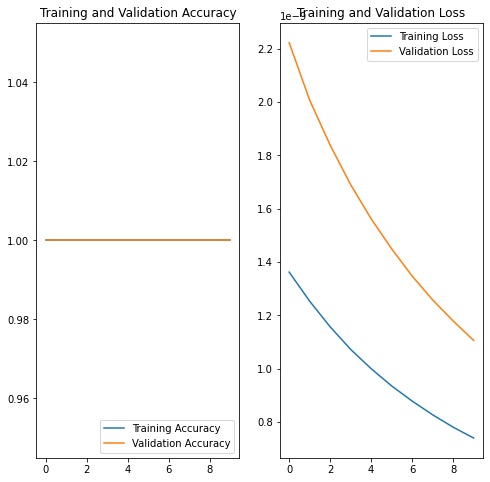

In [0]:
 import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()
